<a href="https://colab.research.google.com/github/hecshzye/nlp-medical-abstract-pubmed-rct/blob/main/nlp_pubmed_rct_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Medical Abstract Classification using Natural Language Processing

### The objective is to build a deep learning model which makes medical research paper abstract easier to read.
  - Dataset used in this project is the `PubMed 200k RCT Dataset for Sequential Sentence Classification in Medical Abstract by Cornell University`: https://arxiv.org/abs/1710.06071
  - The initial deep learning research paper was built with the PubMed 200k RCT.
  - Dataset has about `200,000 labelled Randomized Control Trial abstracts`.
  - The goal of the project was build NLP models with the dataset to classify sentences in sequential order.

 - As the RCT research papers with unstructured abstracts slows down researchers navigating the literature. 
 - The unstructured abstracts are sometimes hard to read and understand especially when it can disrupt time management and deadlines.
 - This NLP model can classify the abstract sentences into its respective roles:
    - Such as `Objective`, `Methods`, `Results` and `Conclusions`.
    

#### The PubMed 200k RCT Dataset - https://github.com/Franck-Dernoncourt/pubmed-rct

#### Similar projects using the dataset:
   - Claim Extraction for Scientific Publications 2018: https://github.com/titipata/detecting-scientific-claim

**Abstract** 

PubMed 200k RCT is new dataset based on PubMed for sequential sentence classification. The dataset consists of approximately 200,000 abstracts of randomized controlled trials, totaling 2.3 million sentences. Each sentence of each abstract is labeled with their role in the abstract using one of the following classes: background, objective, method, result, or conclusion. The purpose of releasing this dataset is twofold. First, the majority of datasets for sequential short-text classification (i.e., classification of short texts that appear in sequences) are small: we hope that releasing a new large dataset will help develop more accurate algorithms for this task. Second, from an application perspective, researchers need better tools to efficiently skim through the literature. Automatically classifying each sentence in an abstract would help researchers read abstracts more efficiently, especially in fields where abstracts may be long, such as the medical field.

**Data Dictionary**

- `PubMed 20k` is a subset of `PubMed 200k`. I.e., any abstract present in `PubMed 20k` is also present in `PubMed 200k`.
- `PubMed_200k_RCT` is the same as `PubMed_200k_RCT_numbers_replaced_with_at_sign`, except that in the latter all numbers had been replaced by `@`. (same for `PubMed_20k_RCT` vs. `PubMed_20k_RCT_numbers_replaced_with_at_sign``).
- Since Github file size limit is 100 MiB, we had to compress `PubMed_200k_RCT\train.7z` and `PubMed_200k_RCT_numbers_replaced_with_at_sign\train.zip`. 
- To uncompress `train.7z`, you may use `7-Zip` on Windows, `Keka` on Mac OS X, or `p7zip` on Linux.

# Importing data and EDA

In [4]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 0), reused 0 (delta 0), pack-reused 30
Unpacking objects: 100% (33/33), done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


### Initial Data exploration and modelling with PubMed_20k dataset

In [5]:
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign

dev.txt  test.txt  train.txt


In [6]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import tensorflow as tf

In [39]:
# functions pre-written for workflow
!wget https://raw.githubusercontent.com/hecshzye/nlp-medical-abstract-pubmed-rct/main/helper_functions.py

--2022-01-16 04:10:45--  https://raw.githubusercontent.com/hecshzye/nlp-medical-abstract-pubmed-rct/main/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6442 (6.3K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]   6.29K  --.-KB/s    in 0s      

2022-01-16 04:10:45 (82.7 MB/s) - ‘helper_functions.py’ saved [6442/6442]



In [40]:
from helper_functions import create_tensorboard_callback, calculate_results, plot_loss_curves

In [7]:
# Function for reading the document
def get_doc(filename):
  with open(filename, "r") as f:
    return f.readlines()

In [9]:
data_dir = "pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt']

In [10]:
# Preprocessing 
train_lines = get_doc(data_dir+"train.txt")
train_lines[:30]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

#### **Data dictionary**

`\t` = tab seperator

`\n` = new line

`###` = abstract ID

`"line_number"` = line position

`"text"` = text line

`"total_lines"` = total number of lines in one abstract

`"target"` = objective of the abstract



In [14]:
# Function for preprocessing the data

def preprocessing_text_with_line_number(filename):
  input_lines = get_doc(filename)
  abstract_lines = ""
  abstract_samples = []

  for line in input_lines:
    if line.startswith("###"):
      abstract_id = line
      abstract_lines = ""
    elif line.isspace():
      abstract_line_split = abstract_lines.splitlines()
       
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {}
        target_text_split = abstract_line.split("\t")
        line_data["target"] = target_text_split[0]
        line_data["text"] = target_text_split[1].lower()
        line_data["line_number"] = abstract_line_number
        line_data["total_lines"] = len(abstract_line_split) - 1
        abstract_samples.append(line_data)

    else:
      abstract_lines += line 
  return abstract_samples    

In [15]:
# Extracting data using the function
train_samples = preprocessing_text_with_line_number(data_dir + "train.txt")
val_samples = preprocessing_text_with_line_number(data_dir + "dev.txt")
test_samples = preprocessing_text_with_line_number(data_dir + "test.txt")
len(train_samples), len(test_samples), len(val_samples)

(180040, 30135, 30212)

In [16]:
train_samples[:10]

[{'line_number': 0,
  'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'total_lines': 11},
 {'line_number': 1,
  'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'total_lines': 11},
 {'line_number': 2,
  'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'total_lines': 11},
 {'line_number': 3,
  'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'total_lines': 11},
 {'line_number': 4,
  'target': 'METHODS',
  'text': 'secondary outcome measures include

In [17]:
# Creating a DataFrame
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


In [18]:
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

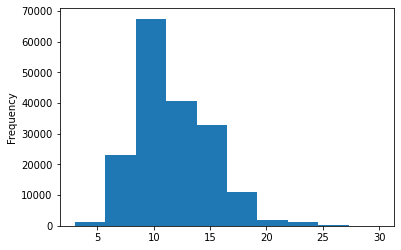

In [19]:
train_df.total_lines.plot.hist();

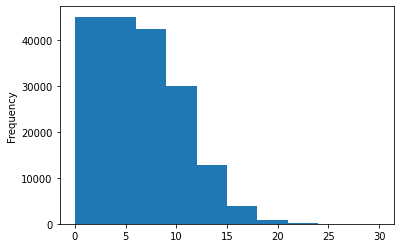

In [20]:
train_df.line_number.plot.hist();

In [25]:
# List of sentences (abstract text lines -> lists)
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()
len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [26]:
train_sentences[:20]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

## Preprocessing for the modelling 

In [29]:
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1, 1))

In [30]:
train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [31]:
# Labelling
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())

In [32]:
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [33]:
# Defining the classes 
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5, array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

# Modellling

### model_1

In [37]:
# model_1
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB

model_1 = Pipeline([
                    ("tf-idf", TfidfVectorizer()),
                    ("clf", MultinomialNB())
])

model_1.fit(X=train_sentences,
            y=train_labels_encoded)

model_1.score(X=val_sentences,
              y=val_labels_encoded)

0.7218323844829869

In [38]:
# Prediction on model_1
model_1_preds = model_1.predict(val_sentences)
model_1_preds

array([4, 1, 3, ..., 4, 4, 1])

In [41]:
# Evaluation 
model_1_results = calculate_results(y_true=val_labels_encoded,
                                  y_pred=model_1_preds)
model_1_results

{'accuracy': 72.1832384482987,
 'f1': 0.6989250353450294,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869}

## model_2 (with sequencing)

In [42]:
# model_2 data preprocessing

from tensorflow.keras import layers

# average length of sentence
sentence_len = [len(sentence.split()) for sentence in train_sentences]
avg_sentence_len = np.mean(sentence_len)
avg_sentence_len

26.338269273494777

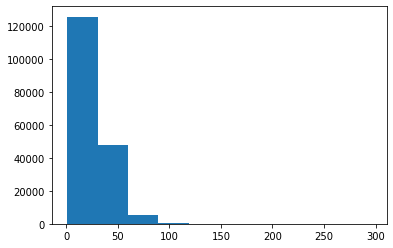

In [43]:
plt.hist(sentence_len, bins=10);

In [49]:
# check the % of sentences length between 0-50 & max sentence length
output_seq_len = int(np.percentile(sentence_len, 95))
output_seq_len, max(sentence_len)

(55, 296)

#### Vectorization

In [50]:
# Section 3.2 states that the vocabulary size is 68,000 - https://arxiv.org/pdf/1710.06071.pdf
max_tokens = 68000 

In [51]:
# text vectorization
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
text_vectorizer = TextVectorization(max_tokens=max_tokens,
                                    output_sequence_length=55)
# adapting text vectorizer to training sentences
text_vectorizer.adapt(train_sentences)

# testing the text vectorizer
import random 
target_sentence = random.choice(train_sentences)
print(f"Text:\n{target_sentence}")
print(f"\nLength of text: {len(target_sentence.split())}")
print(f"\nVectorized text:\n{text_vectorizer([target_sentence])}")

Text:
the frequency of periods with complete motor unit relaxation ( emg gaps ) decreased acutely in the hours after training .

Length of text: 21

Vectorized text:
[[   2  400    4 1242    7  488  600  835 2370 4787 6526  212 5380    5
     2  227   21  155    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]


In [52]:
# Number of words in the training vocabulary
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f"Total number of words in vocabulary: {len(rct_20k_text_vocab)}"),
print(f"Most common words: {rct_20k_text_vocab[:5]}")
print(f"Least common words: {rct_20k_text_vocab[-5:]}")

Total number of words in vocabulary: 64841
Most common words: ['', '[UNK]', 'the', 'and', 'of']
Least common words: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [53]:
# Configuration 
text_vectorizer.get_config()

{'batch_input_shape': (None,),
 'dtype': 'string',
 'idf_weights': None,
 'max_tokens': 68000,
 'name': 'text_vectorization',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'ragged': False,
 'sparse': False,
 'split': 'whitespace',
 'standardize': 'lower_and_strip_punctuation',
 'trainable': True,
 'vocabulary': None}

In [56]:
# Embedding token layer
token_embed = layers.Embedding(input_dim=len(rct_20k_text_vocab),
                              output_dim=128,
                              mask_zero=True,
                              name="token_embedding")

# View embedded token layer
print(f"before vectorization:\n{target_sentence}\n")
vectorized__sentence = text_vectorizer([target_sentence])
print(f"after vectorization:\n{vectorized__sentence}\n")
embedded_sentence = token_embed(vectorized__sentence)
print(f"after embedding:\n{embedded_sentence}\n")
print(f"shape after embedding: {embedded_sentence.shape}")

before vectorization:
the frequency of periods with complete motor unit relaxation ( emg gaps ) decreased acutely in the hours after training .

after vectorization:
[[   2  400    4 1242    7  488  600  835 2370 4787 6526  212 5380    5
     2  227   21  155    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]

after embedding:
[[[ 0.0435272  -0.02852956 -0.04262494 ... -0.03197289  0.00967293
   -0.00197263]
  [ 0.02235366  0.00409802  0.01699072 ... -0.02159172  0.04524991
   -0.0215061 ]
  [ 0.02058617  0.04849395 -0.0199494  ... -0.00714713 -0.00829104
    0.00729998]
  ...
  [ 0.01047357  0.02430047 -0.04110395 ... -0.01003435  0.04032923
   -0.0089737 ]
  [ 0.01047357  0.02430047 -0.04110395 ... -0.01003435  0.04032923
   -0.0089737 ]
  [ 0.01047357  0.02430047 -0.04110395 ... -0.01003435  0.04032923
   -0.0089737 ]]]

shape after embedding: (